In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from master_function import import_cot_data, data_preprocessing_multi
from master_function import plot_train_test_values, calculate_directional_accuracy
from sklearn.metrics import mean_squared_error

# Calling the function and preprocessing the data
CAD = 'CANADIAN DOLLAR - CHICAGO MERCANTILE EXCHANGE'
NAS = 'NASDAQ-100 Consolidated - CHICAGO MERCANTILE EXCHANGE'
data = import_cot_data(2016, 2024, NAS)
# data = np.array(data.iloc[:, -1], dtype = np.float64)

Selected: traders_in_financial_futures_fut
Downloaded single year data from: 2016
Stored the file FinFutYY.txt in the working directory.
Selected: traders_in_financial_futures_fut
Downloaded single year data from: 2017
Stored the file FinFutYY.txt in the working directory.
Selected: traders_in_financial_futures_fut
Downloaded single year data from: 2018
Stored the file FinFutYY.txt in the working directory.
Selected: traders_in_financial_futures_fut
Downloaded single year data from: 2019
Stored the file FinFutYY.txt in the working directory.
Selected: traders_in_financial_futures_fut
Downloaded single year data from: 2020
Stored the file FinFutYY.txt in the working directory.
Selected: traders_in_financial_futures_fut
Downloaded single year data from: 2021
Stored the file FinFutYY.txt in the working directory.
Selected: traders_in_financial_futures_fut
Downloaded single year data from: 2022
Stored the file FinFutYY.txt in the working directory.
Selected: traders_in_financial_futures_fu

d:\repos\Trading-Strategies\lstm\master_function.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Net_COT'] = (data['Pct_of_OI_Lev_Money_Long_All'] - \


In [2]:
# Read the BTC/USD data from CSV file
btc_usd_df = pd.read_csv('../data/btcusd.csv')

# Convert the 'Date' column to datetime
btc_usd_df['Date'] = pd.to_datetime(btc_usd_df['time']/1000, unit='s')

# Sort the dataframe by date
btc_usd_df = btc_usd_df.sort_values('Date')

# Resample the data to daily intervals
btc_usd_df = btc_usd_df.set_index('Date').resample('d').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).reset_index()

# Display the first few rows of the dataframe
print(btc_usd_df.tail())

           Date     open     high      low    close       volume
3838 2023-10-04  27431.0  27846.0  27211.0  27813.0   889.626490
3839 2023-10-05  27815.0  28134.0  27369.0  27418.0  1444.942181
3840 2023-10-06  27418.0  28297.0  27195.0  27942.0  1622.530649
3841 2023-10-07  27927.0  28026.0  27840.0  27967.0   447.166805
3842 2023-10-08  27964.0  28093.0  27888.0  27912.0    91.937715


In [3]:
import requests
import datetime

# Function to fetch data from Bitfinex API
def fetch_bitfinex_data(symbol, timeframe, start_time, end_time):
    url = f"https://api-pub.bitfinex.com/v2/candles/trade:{timeframe}:{symbol}/hist"
    params = {
        "start": int(start_time.timestamp() * 1000),
        "end": int(end_time.timestamp() * 1000),
        "limit": 10000,
        "sort": 1
    }
    response = requests.get(url, params=params)
    return response.json()

# Set parameters
symbol = "tBTCUSD"
timeframe = "1D"
start_date = datetime.datetime(2023, 10, 8)
end_date = datetime.datetime.now()

# Fetch data from Bitfinex
bitfinex_data = fetch_bitfinex_data(symbol, timeframe, start_date, end_date)

# Convert Bitfinex data to DataFrame
bitfinex_df = pd.DataFrame(bitfinex_data, columns=['timestamp', 'open', 'close', 'high', 'low', 'volume'])
bitfinex_df['Date'] = pd.to_datetime(bitfinex_df['timestamp'], unit='ms')
bitfinex_df = bitfinex_df.drop('timestamp', axis=1)

# Reorder columns to match btc_usd_df
bitfinex_df = bitfinex_df[['Date', 'open', 'high', 'low', 'close', 'volume']]

# Concatenate the new data to btc_usd_df
btc_usd_df = pd.concat([btc_usd_df, bitfinex_df], ignore_index=True)

# Remove any potential duplicates based on the 'Date' column
btc_usd_df = btc_usd_df.drop_duplicates(subset='Date', keep='last')

# Sort the dataframe by date
btc_usd_df = btc_usd_df.sort_values('Date')

# Reset the index
btc_usd_df = btc_usd_df.reset_index(drop=True)

# Calculate the percentage change in the 'close' column
btc_usd_df['Close_Pct_Change'] = btc_usd_df['close'].pct_change() * 100

# Round the percentage change to 2 decimal places
btc_usd_df['Close_Pct_Change'] = btc_usd_df['Close_Pct_Change'].round(2)


# Display the last few rows of the updated dataframe
print(btc_usd_df.tail())


           Date     open     high      low    close       volume  \
4197 2024-09-27  65308.0  66587.0  64987.0  65928.0   667.569331   
4198 2024-09-28  65928.0  66410.0  65568.0  66014.0   105.242558   
4199 2024-09-29  65999.0  66193.0  65574.0  65762.0    87.510451   
4200 2024-09-30  65759.0  65759.0  63005.0  63468.0  1038.776508   
4201 2024-10-01  63468.0  63635.0  63142.0  63459.0    14.247143   

      Close_Pct_Change  
4197              0.95  
4198              0.13  
4199             -0.38  
4200             -3.49  
4201             -0.01  


C:\Users\SamAl\AppData\Local\Temp\ipykernel_12268\3070915398.py:46: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  btc_usd_df['Close_Pct_Change'] = btc_usd_df['close'].pct_change() * 100


In [4]:
cot_df = data.copy()

# Calculate the change in Net_COT and add it as a new column
cot_df['Change_COT'] = cot_df['Net_COT'] - cot_df['Net_COT'].shift(1)

# Display the updated dataframe
cot_df.tail(10)

,Market_and_Exchange_Names,Report_Date_as_YYYY-MM-DD,Pct_of_OI_Dealer_Long_All,Pct_of_OI_Dealer_Short_All,Pct_of_OI_Lev_Money_Long_All,Pct_of_OI_Lev_Money_Short_All,Net_COT,Change_COT
964,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-07-23,7.6,34.9,16.0,29.1,14.2,4.8
963,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-07-30,7.0,36.6,14.8,27.0,17.4,3.2
962,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-08-06,6.6,40.7,13.7,26.8,21.0,3.6
961,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-08-13,8.1,37.4,11.0,28.6,11.7,-9.3
960,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-08-20,11.3,33.3,10.7,32.8,-0.1,-11.8
959,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-08-27,11.0,37.9,10.8,29.7,8.0,8.1
958,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-09-03,11.7,38.3,10.3,28.6,8.3,0.3
957,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-09-10,11.0,38.2,12.4,25.2,14.4,6.1
956,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-09-17,11.5,34.3,8.2,27.6,3.4,-11.0
955,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-09-24,14.5,39.7,11.0,31.5,4.7,1.3


In [5]:
# Create a new 'Date' column as the index while keeping 'Report_Date_as_YYYY-MM-DD'
cot_df['Date'] = pd.to_datetime(cot_df['Report_Date_as_YYYY-MM-DD'])
cot_df = cot_df.set_index('Date')

# Add COT_Trigger column before resampling
cot_df['COT_Trigger'] = 1

# Store the original dates
original_dates = cot_df.index

# Resample and forward fill using the new 'Date' index
cot_df = cot_df.resample('D').ffill()

# Reset the index to make 'Date' a column again
cot_df = cot_df.reset_index()

# Ensure 'Report_Date_as_YYYY-MM-DD' is not modified during resampling
cot_df['Report_Date_as_YYYY-MM-DD'] = pd.to_datetime(cot_df['Report_Date_as_YYYY-MM-DD'])

# Set COT_Trigger to 1 only for original dates, 0 for new rows
cot_df['COT_Trigger'] = cot_df['Date'].isin(original_dates).astype(int)

# Sort the dataframe by the new 'Date' column
cot_df = cot_df.sort_values('Date')

# Reset the index
cot_df = cot_df.reset_index(drop=True)

# Display the first few rows of the updated dataframe to verify the changes
cot_df.tail(10)


,Date,Market_and_Exchange_Names,Report_Date_as_YYYY-MM-DD,Pct_of_OI_Dealer_Long_All,Pct_of_OI_Dealer_Short_All,Pct_of_OI_Lev_Money_Long_All,Pct_of_OI_Lev_Money_Short_All,Net_COT,Change_COT,COT_Trigger
3176,2024-09-15,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-09-10,11.0,38.2,12.4,25.2,14.4,6.1,0
3177,2024-09-16,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-09-10,11.0,38.2,12.4,25.2,14.4,6.1,0
3178,2024-09-17,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-09-17,11.5,34.3,8.2,27.6,3.4,-11.0,1
3179,2024-09-18,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-09-17,11.5,34.3,8.2,27.6,3.4,-11.0,0
3180,2024-09-19,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-09-17,11.5,34.3,8.2,27.6,3.4,-11.0,0
3181,2024-09-20,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-09-17,11.5,34.3,8.2,27.6,3.4,-11.0,0
3182,2024-09-21,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-09-17,11.5,34.3,8.2,27.6,3.4,-11.0,0
3183,2024-09-22,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-09-17,11.5,34.3,8.2,27.6,3.4,-11.0,0
3184,2024-09-23,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-09-17,11.5,34.3,8.2,27.6,3.4,-11.0,0
3185,2024-09-24,NASDAQ-100 Consolidated - CHICAGO MERCANTILE E...,2024-09-24,14.5,39.7,11.0,31.5,4.7,1.3,1


In [6]:
# Print rows from btc_usd_df for dates 2016-09-08 through 2016-09-16
start_date = '2016-08-01'
end_date = '2016-08-16'

# Convert 'Date' column to datetime if it's not already
btc_usd_df['Date'] = pd.to_datetime(btc_usd_df['Date'])

# Filter the dataframe for the specified date range
date_range_df = btc_usd_df[(btc_usd_df['Date'] >= start_date) & (btc_usd_df['Date'] <= end_date)]

# Display the filtered rows
print(f"BTC/USD data from {start_date} to {end_date}:")
print(date_range_df)

# If no data is found in the range, print a message
if date_range_df.empty:
    print(f"No data found in btc_usd_df for the date range {start_date} to {end_date}")


BTC/USD data from 2016-08-01 to 2016-08-16:
           Date    open    high     low   close        volume  \
1218 2016-08-01  622.83  627.35  605.01  608.29  31426.516030   
1219 2016-08-02  608.24  615.29  595.00  604.10  33013.962338   
1220 2016-08-03     NaN     NaN     NaN     NaN      0.000000   
1221 2016-08-04     NaN     NaN     NaN     NaN      0.000000   
1222 2016-08-05     NaN     NaN     NaN     NaN      0.000000   
1223 2016-08-06     NaN     NaN     NaN     NaN      0.000000   
1224 2016-08-07     NaN     NaN     NaN     NaN      0.000000   
1225 2016-08-08     NaN     NaN     NaN     NaN      0.000000   
1226 2016-08-09     NaN     NaN     NaN     NaN      0.000000   
1227 2016-08-10  579.00  614.50  579.00  590.28  21352.111119   
1228 2016-08-11  590.50  599.75  584.59  591.27  15295.562428   
1229 2016-08-12  591.26  593.00  584.00  585.50   6287.987600   
1230 2016-08-13  585.50  590.02  582.00  583.73   6420.322837   
1231 2016-08-14  583.73  583.75  564.00  569.4

In [7]:
start_date = '2016-08-10'

# Convert start_date to datetime
start_date = pd.to_datetime(start_date)

# Merge the dataframes on the 'Date' column
merged_df = pd.merge(btc_usd_df, cot_df[['Date', 'Change_COT']], on='Date', how='left')

# Fill NaN values in Change_COT with the last valid number
merged_df['Change_COT'] = merged_df['Change_COT'].fillna(method='ffill')

# Filter the merged_df to start from the specified start_date
merged_df = merged_df[merged_df['Date'] >= start_date]

# Reset the index after filtering
merged_df = merged_df.reset_index(drop=True)

merged_df.head(10)

C:\Users\SamAl\AppData\Local\Temp\ipykernel_12268\29828619.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['Change_COT'] = merged_df['Change_COT'].fillna(method='ffill')


,Date,open,high,low,close,volume,Close_Pct_Change,Change_COT
0,2016-08-10,579.00,614.50,579.00,590.28,21352.111119,-2.29,-1.0
1,2016-08-11,590.50,599.75,584.59,591.27,15295.562428,0.17,-1.0
2,2016-08-12,591.26,593.00,584.00,585.50,6287.987600,-0.98,-1.0
3,2016-08-13,585.50,590.02,582.00,583.73,6420.322837,-0.30,-1.0
4,2016-08-14,583.73,583.75,564.00,569.41,7530.309042,-2.45,-1.0
5,2016-08-15,569.65,575.75,562.99,564.64,7650.169517,-0.84,-1.0
6,2016-08-16,564.55,579.00,564.00,574.17,6221.584671,1.69,-2.7
7,2016-08-17,574.23,578.50,569.00,571.83,5033.031213,-0.41,-2.7
8,2016-08-18,571.95,578.75,569.71,572.21,6000.622989,0.07,-2.7
9,2016-08-19,572.33,577.25,570.82,573.51,2942.517267,0.23,-2.7


In [8]:
# Suppose 'full_data' is a DataFrame with your features and target
features = merged_df[['volume', 'Change_COT']].values
target = merged_df['Close_Pct_Change'].values

print(features.shape)
print(target.shape)

(2975, 2)
(2975,)


In [9]:
# Check for NaN in features and target
print("Any NaN in features:", np.isnan(features).any())
print("Any NaN in target:", np.isnan(target).any())

# Check for Inf in features and target
print("Any Inf in features:", np.isinf(features).any())
print("Any Inf in target:", np.isinf(target).any())

Any NaN in features: False
Any NaN in target: False
Any Inf in features: False
Any Inf in target: False


In [10]:
# Setting the hyperparameters
num_lags = 50
target_lag = 1
train_test_split = 0.80
neurons = 200
num_epochs = 200
batch_size = 4

# Preprocess the data
x_train, y_train, x_test, y_test = data_preprocessing_multi(features, target, num_lags, target_lag, train_test_split)

# Verify shapes
print("x_train.shape:", x_train.shape)  # Expected: (num_samples, num_lags, num_features)
print("y_train.shape:", y_train.shape)  # Expected: (num_samples,)
print("x_test.shape:", x_test.shape)
print("y_test.shape:", y_test.shape)

num_features = x_train.shape[2]

# Reshape the data to 3D for LSTM input
x_train = x_train.reshape((-1, num_lags, num_features))
x_test = x_test.reshape((-1, num_lags, num_features))

# Create the LSTM model
model = Sequential()

# Adding a first layer
model.add(LSTM(units = neurons, input_shape = (num_lags, num_features)))

# Adding a second layer
model.add(Dense(neurons, activation = 'relu')) 

# Adding the output layer 
model.add(Dense(units = 1))

# Compiling the model
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

# Fitting the model
model.fit(x_train, y_train, epochs = num_epochs, batch_size = batch_size)

x_train.shape: (2340, 50, 2)
y_train.shape: (2340,)
x_test.shape: (585, 50, 2)
y_test.shape: (585,)


d:\repos\Trading-Strategies\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
585/585 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.1221
Epoch 2/200
585/585 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.9721
Epoch 3/200
585/585 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.0633
Epoch 4/200
585/585 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.0518
Epoch 5/200
585/585 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.0705
Epoch 6/200
585/585 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.0082
Epoch 7/200
585/585 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9655
Epoch 8/200
585/585 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.9555
Epoch 9/200
585/585 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.9269
Epoch 10/200
585/585 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.9162
Epoch 11/200
585/585 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.9968
Epoch 12/200
585/585 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.1142
Epoch 13/200
585/585 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.9886
Epoch 14/200
585/585 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.1017
Epoch 15/200
585/585 ━━━━━━━━━━━━━━━━━━━━ 4

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


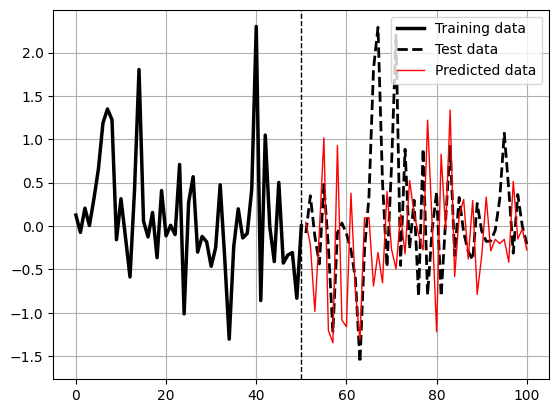

---
Directional Accuracy Train =  93.59 %
Directional Accuracy Test =  53.42 %
RMSE Train =  0.1648807015
RMSE Test =  0.8065374106
Correlation In-Sample Predicted/Train =  0.986
Correlation Out-of-Sample Predicted/Test =  0.058
---


In [11]:
def plot_train_test_values(window, train_window, target_lag, y_train, y_test, y_predicted):
    prediction_window = window
    first = train_window
    second = window - first
    y_predicted = np.reshape(y_predicted, (-1, 1))
    y_test = np.reshape(y_test, (-1, 1))
    
    # Adjust the plotting array to account for the target lag
    plotting_time_series = np.zeros((prediction_window + target_lag, 3))
    plotting_time_series[0:first, 0] = y_train[-first:]
    plotting_time_series[first + target_lag:, 1] = y_test[0:second - target_lag + 1, 0]
    plotting_time_series[first + target_lag:, 2] = y_predicted[0:second - target_lag + 1, 0]
    
    # Set initial values to NaN where data isn't available
    plotting_time_series[0:first + target_lag, 1:] = np.nan
    plotting_time_series[first + target_lag:, 0] = np.nan
    
    plt.plot(plotting_time_series[:, 0], label='Training data', color='black', linewidth=2.5)
    plt.plot(plotting_time_series[:, 1], label='Test data', color='black', linestyle='dashed', linewidth=2)
    plt.plot(plotting_time_series[:, 2], label='Predicted data', color='red', linewidth=1)
    plt.axvline(x=first, color='black', linestyle='--', linewidth=1)
    plt.grid()
    plt.legend()
    plt.show()


# Predicting in the training set for illustrative purposes
y_predicted_train = model.predict(x_train)

# Predicting in the test set
y_predicted = model.predict(x_test)

# Plotting
plot_train_test_values(100, 50, target_lag, y_train, y_test, y_predicted)

# Performance evaluation
print('---')
print('Directional Accuracy Train = ', round(calculate_directional_accuracy(y_predicted_train, y_train), 2), '%')
print('Directional Accuracy Test = ', round(calculate_directional_accuracy(y_predicted, y_test), 2), '%')
print('RMSE Train = ', round(np.sqrt(mean_squared_error(y_predicted_train, y_train)), 10))
print('RMSE Test = ', round(np.sqrt(mean_squared_error(y_predicted, y_test)), 10))
print('Correlation In-Sample Predicted/Train = ', round(np.corrcoef(np.reshape(y_predicted_train, (-1)), y_train)[0][1], 3))
print('Correlation Out-of-Sample Predicted/Test = ', round(np.corrcoef(np.reshape(y_predicted, (-1)), np.reshape(y_test, (-1)))[0][1], 3))
print('---')
